# Installing Packages

In [7]:
using  Dates, Roots, Lux, DiffEqSensitivity, FinancialToolbox, Random, Plots, Statistics, Flux, DiffEqFlux, StochasticDiffEq, DiffEqBase.EnsembleAnalysis, DifferentialEquations;

# Generating Geomteric Brownian Motion Stock Paths
$dS_t = rS_tdt + \sigma S_tdW_t$ <br>
$S_0 = 100$ <br>
$r = 8\%$ <br>
$\sigma = 20\%$ <br>
We generate a single GBM stock path, which we will use to model our neural SDE. We use an Euler-Maruyama approximation to generate paths from our neural SDE, with 100 timesteps of size 0.01, so we generate the stock price at 100 different times.   

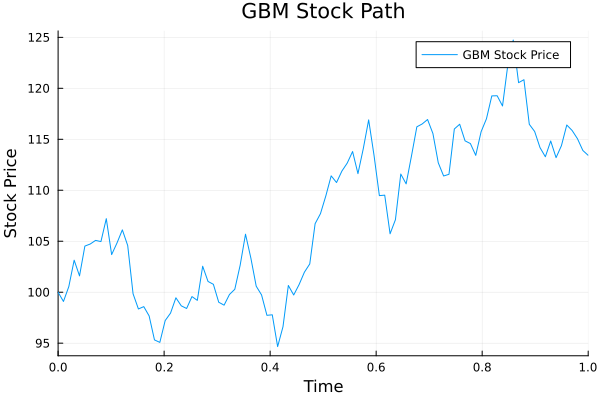

In [228]:
Random.seed!(1)
S₀ = Float32[100];
r = 0.08; 
σ = 0.2;  
tspan = (0.0,1.0); # The timespan for the problem.
datasize = 100;
tsteps = range(tspan[1], tspan[2], length = datasize);
dt = tsteps[2]; 
GBM_drift(S,p,t) = r*S; # The drift function in the SDE.
GBM_diffusion(S,p,t) = σ*S; # The noise function in the SDE.
GBM = SDEProblem(GBM_drift,GBM_diffusion,S₀,tspan); # GBM.  

Solution = solve(GBM, EM(),dt = dt); # Trajectories is the number of simulations being run. EM() doesn't do a good job, or can use the analytical solution. We use a fast adaptive method which is very close to the analytical. Compare this to EM in dissertation. 
Stock_path = Solution[1,:]
plot(Solution,title="GBM Stock Path",label = "GBM Stock Price",xlabel = "Time",ylabel = "Stock Price")

# Initialising the Neural SDE
We setup the neural SDE by replacing the diffusion component of the GBM with a neural network. The architecture of the neural network simply consists of a an input and output layer with no hidden layers, as we are essentially using the neural network to approximate a straight line, $\sigma S_t$. We use the same drift condition as the GBM to ensure no-arbitrage. As you can see by the plot, we need to train the neural network to get a better approximation. We also generate a stock path under the neural SDE, to show this point that we still need to conduct training to get a better approximation. 

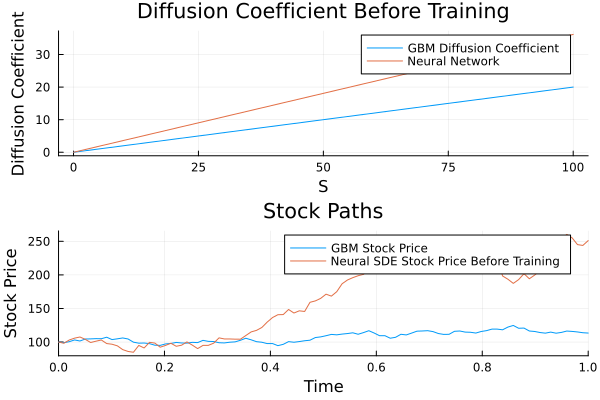

In [314]:
gridsize = 100;
Func(x) = σ*x;
X_Training = collect(range(0,stop=100,length=gridsize));
Y_Training = Func.(X_Training);

gridsize1 = 20
X_Testing = collect(range(0,stop=100,length=gridsize1));
Y_Testing = Func.(X_Testing)

data = []
for i in 1:length(X_Training)
    push!(data, ([X_Training[i]], Y_Training[i]))
end

model = Flux.Chain(Flux.Dense(1,1))  
plt1 = plot(X_Testing ,[Y_Testing  model(X_Testing')'],title="Diffusion Coefficient Before Training",label=["GBM Diffusion Coefficient" "Neural Network"], xlabel = "S",ylabel = "Diffusion Coefficient") # before training

NSDE_diffusion_Before(S,p,t) = model(S);
NSDE_Before = SDEProblem(GBM_drift,NSDE_diffusion_Before,S₀,tspan);  
Solution_Before = solve(NSDE_Before, EM(),dt = dt); 
before_data = model(X_Testing')'[:,1]
plot(Solution,title="GBM Stock Path",label = "GBM Stock Price")
plt2 = plot!(Solution_Before,title="Stock Paths",label = "Neural SDE Stock Price Before Training", xlabel = "Time",ylabel = "Stock Price")

plt = plot(plt1, plt2, layout = (2, 1))

# Training the Neural Network
Using the training data previously specified, we train the neural network approximating the diffusion coefficent. As can be seen by the plot, the neural network provides a good approximation. 

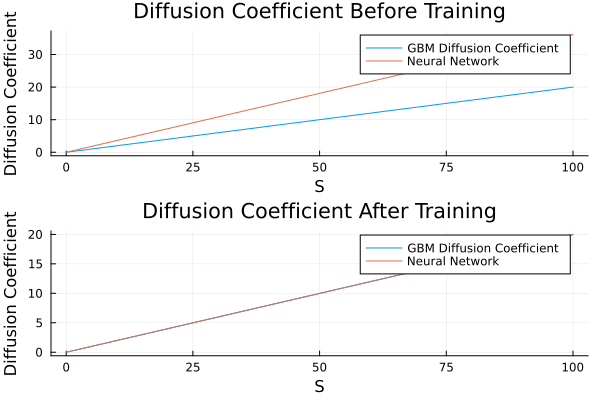

In [315]:
t1 = now()
loss(x, y) = Flux.mse(model(x), y)
opt = Adam()
ps = Flux.params(model)

for epoch in 1:200
    Flux.train!(loss, ps, data, opt);
end
after_data = model(X_Testing')'[:,1]

plt3 = plot(X_Testing ,[Y_Testing  model(X_Testing')'],title="Diffusion Coefficient After Training",label=["GBM Diffusion Coefficient" "Neural Network"], xlabel = "S",ylabel = "Diffusion Coefficient") # before training

plt4 = plot(plt1, plt3, layout = (2, 1))

In [242]:
t2 = now()
println(t2-t1)

2568 milliseconds


# Generating Stock Paths from our Neural SDE
Now that we have shown that our neural network representing the diffusion coefficient provides a good approximation, we generate stock paths from the neural SDE and compare it to the stock paths produced by GBM.

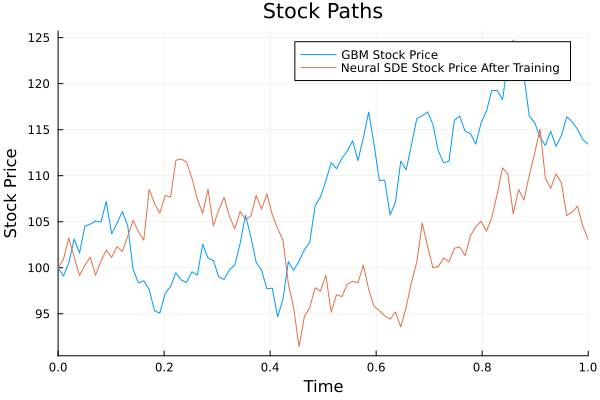

In [71]:
NSDE_diffusion(S,p,t) = model(S);
NSDE = SDEProblem(GBM_drift,NSDE_diffusion,S₀,tspan); 

NSDE_Solution = solve(NSDE,EM(),dt = dt); # Trajectories is the number of simulations being run. EM() doesn't do a good job, or can use the analytical solution. We use a fast adaptive method which is very close to the analytical. Compare this to EM in dissertation. 
NSDE_Stock_path = NSDE_Solution[1,:]

plot(Solution,title="GBM Stock Path",label = "GBM Stock Price")
plot!(NSDE_Solution,title="Stock Paths",label = "Neural SDE Stock Price After Training", xlabel = "Time",ylabel = "Stock Price")

# Generating Multiple Trajectories
We generate 10 000 samples, which we will use to conduct a Monte Carlo simulation to price vanilla call options for various strikes. 

In [243]:
ensemble_prob = EnsembleProblem(GBM);
ensemble_sol = solve(ensemble_prob, EM(),dt = dt, trajectories = 10000); # We generate data from the average of 10,000 runs of the SDE.
ensemble_sum = EnsembleSummary(ensemble_sol);

ensemble_prob_NSDE = EnsembleProblem(NSDE);
ensemble_sol_NSDE = solve(ensemble_prob_NSDE, EM(),dt = dt, trajectories = 10000); # We generate data from the average of 10,000 runs of the SDE.
ensemble_sum_NSDE = EnsembleSummary(ensemble_sol_NSDE);

stock_price_GBM = ensemble_sol[1,end,:];
stock_price_NSDE = ensemble_sol_NSDE[1,end,:] ;

# Option Pricing 
We now use Monte Carlo simulation to price options under the GBM and the neural SDE, and see if the neural SDE provides a good approximation.

In [244]:
# Vanilla Call Price Function. 

function call_pricer(stock_price,K)
    A = stock_price-ones(size(stock_price))*K
    B = maximum([A zeros(size(A))],dims=2)
    return exp(-r*tspan[2])*mean(B)
end 

call_pricer (generic function with 1 method)

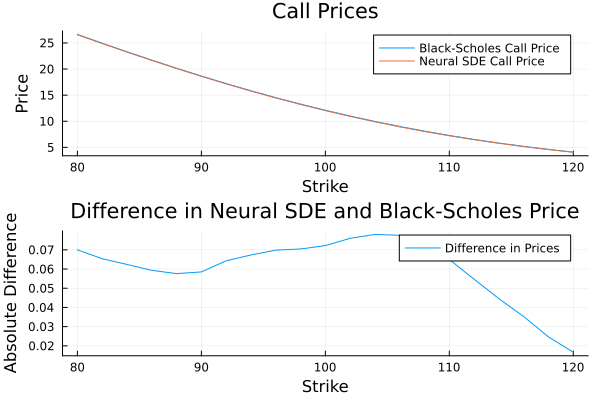

In [355]:
K = range(80, 120, length = 21)
K1 = 100 ./ range(80, 120, length = 21)
K1 = K1[:,1]
log_moneyness = log.(K1)
NSDE_Price = zeros(1,length(K))
BS_Price = zeros(1,length(K))


for i in 1:length(K)
    NSDE_Price[i] = call_pricer(stock_price_NSDE,K[i])
    BS_Price[i] = blsprice(100,K[i],r,tspan[2],σ,0.0)
end 


#plot(K,GBM_Price',label = "GBM Call Price")
plot(K,BS_Price',label = "Black-Scholes Call Price")
plt5 = plot!(K,NSDE_Price',title="Call Prices",label = "Neural SDE Call Price",xlabel = "Strike",ylabel = "Price")
Difference = abs.(BS_Price .- NSDE_Price)';
plt6 = plot(K,Difference,title="Difference in Neural SDE and Black-Scholes Price",label = "Difference in Prices",xlabel = "Strike",ylabel = "Absolute Difference")
plt = plot(plt5, plt6, layout = (2, 1))

Using a larger sample size for the Monte Carlo simulation. We now use 100 000 to see that the neural SDE option prices coverge to the GBM option prices. 

In [269]:
ensemble_prob_NSDE1 = EnsembleProblem(NSDE);
ensemble_sol_NSDE1 = solve(ensemble_prob_NSDE1, EM(),dt = dt, trajectories = 100000); # We generate data from the average of 10,000 runs of the SDE.
ensemble_sum_NSDE1 = EnsembleSummary(ensemble_sol_NSDE1);

stock_price_NSDE1 = ensemble_sol_NSDE1[1,end,:] ;

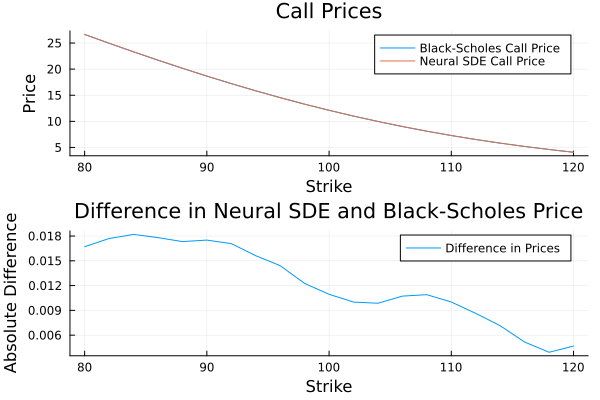

In [350]:
NSDE_Price1 = zeros(1,length(K))
BS_Price1 = zeros(1,length(K))

for i in 1:length(K)
    NSDE_Price1[i] = call_pricer(stock_price_NSDE1,K[i])
    BS_Price1[i] = blsprice(100,K[i],r,tspan[2],σ,0.0)
end 

plot(K,BS_Price1',label = "Black-Scholes Call Price")
plt7 = plot!(K,NSDE_Price1',title="Call Prices",label = "Neural SDE Call Price",xlabel = "Strike",ylabel = "Price")
Difference1 = abs.(BS_Price1 .- NSDE_Price1)';
plt8 = plot(K,Difference1,title="Difference in Neural SDE and Black-Scholes Price",label = "Difference in Prices",xlabel = "Strike",ylabel = "Absolute Difference")
plt = plot(plt7, plt8, layout = (2, 1))

In [351]:
# Implied vol
function bsvol(S0, K, r, T, price_d)
    f(x) = blsprice(S0, K, r, T, x, 0.0) - price_d
    vol = find_zero(f , 0.2)
    return vol
end


BS_Vol = zeros(1,length(K))
Vol_After = zeros(1,length(K))

for i in 1:length(K)
    BS_Vol[i] = blsimpv(100,K[i],r,tspan[2],BS_Price1[i])
    Vol_After[i] = blsimpv(100,K[i],r,tspan[2],NSDE_Price1[i])
end 

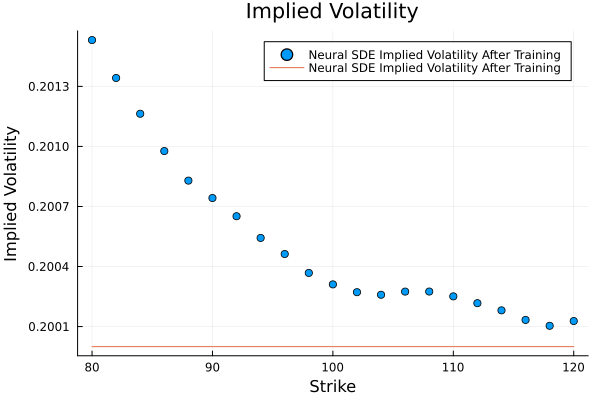

In [352]:
plt19 = scatter(K,Vol_After',title="Implied Volatility",label = "Neural SDE Implied Volatility After Training",xlabel = "Strike",ylabel = "Implied Volatility");
plt20 = plot!(K,BS_Vol',title="Implied Volatility",label = "Neural SDE Implied Volatility After Training",xlabel = "Strike",ylabel = "Implied Volatility")

# Plotting

In [253]:
using Gadfly, Fontconfig, Cairo, DataFrames, Compose;

In [369]:
# Diffusion training
layer4 = layer(x=X_Testing, y=Y_Testing, Geom.line,Theme(line_width = 1pt,default_color=colorant"#6A5ACD"))
layer5 = layer(x=X_Testing, y=before_data,Geom.point,shape=[Gadfly.Shape.xcross],Theme(point_size =2.5pt,line_width = 1pt,default_color=colorant"#FF4500"))
p3 = Gadfly.plot(layer5,layer4,Theme(key_label_font_size=6pt,major_label_font_size=7pt),Guide.ylabel("Diffusion Coefficient"), Guide.xlabel("Stock Price"),Guide.manual_color_key("", ["Neural Network Before Training","Black-Scholes Diffusion Coefficient"],["#FF6347","#6A5ACD"],pos=[0.05w,-0.45h],shape=[Gadfly.Shape.xcross,Gadfly.Shape.hline]))


layer6 = layer(x=X_Testing, y= after_data,Geom.point,shape=[Gadfly.Shape.xcross],Theme(point_size =2.5pt,line_width = 1pt,default_color=colorant"#FF4500"))
p4 = Gadfly.plot(layer6,layer4,Guide.yticks(ticks = [ 0 5 10 15 20 ]),Theme(key_label_font_size=6pt,major_label_font_size=7pt),Guide.ylabel("Diffusion Coefficient"), Guide.xlabel("Stock Price"),Guide.manual_color_key("", ["Neural Network After Training","Black-Scholes Diffusion Coefficient"],["#FF6347","#6A5ACD"],pos=[0.05w,-0.45h],shape=[Gadfly.Shape.xcross,Gadfly.Shape.hline]))
plt = hstack(p3,p4)
#draw(PDF("myplot10.pdf", 14cm, 7cm), plt)




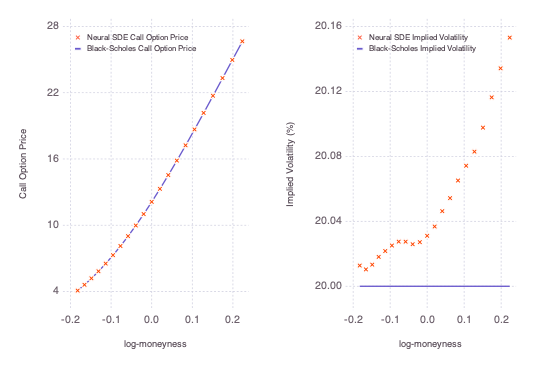

In [375]:
# Plotting call prices
NSDE_Call_Prices = NSDE_Price1[1,:];
BS_Call_Prices = BS_Price1[1,:];
NSDE_Call_Vol = Vol_After[1,:].*100;
BS_Call_Vol = BS_Vol[1,:].*100;

layer7 = layer(x= log_moneyness, y=NSDE_Call_Prices,Geom.point,shape=[Gadfly.Shape.xcross],Theme(point_size =2.5pt,default_color=colorant"#FF4500"))
layer8 = layer(x=log_moneyness, y=BS_Call_Prices,Geom.line,Theme(line_width = 1pt,default_color=colorant"#6A5ACD"))
p5 = Gadfly.plot(layer7,layer8,Guide.yticks(ticks = [ 4    10    16    22    28]),Theme(key_label_font_size=6pt,major_label_font_size=7pt),Guide.ylabel("Call Option Price"), Guide.xlabel("log-moneyness"),Guide.manual_color_key("", ["Neural SDE Call Option Price","Black-Scholes Call Option Price"],["#FF6347","#6A5ACD"],pos=[0.05w,-0.45h],shape=[Gadfly.Shape.xcross, Gadfly.Shape.hline]),Coord.cartesian(xmin=-0.2, xmax=0.22, ymin=3, ymax=28))


layer9 = layer(x=log_moneyness, y= NSDE_Call_Vol,Geom.point, shape=[Gadfly.Shape.xcross],Theme(point_size =2.5pt,default_color=colorant"#FF4500"))
layer8 = layer(x=log_moneyness, y=BS_Call_Vol, Geom.line,Theme(line_width = 1pt,default_color=colorant"#6A5ACD"))
p6 = Gadfly.plot(layer8,layer9,Guide.yticks(ticks = [ 20.00    20.04    20.08    20.12  20.16]),Theme(key_label_font_size=6pt,major_label_font_size=7pt),Guide.ylabel("Implied Volatility (%)"), Guide.xlabel("log-moneyness"),Guide.manual_color_key("", ["Neural SDE Implied Volatility","Black-Scholes Implied Volatility"],["#FF6347","#6A5ACD"],pos=[0.05w,-0.45h],shape=[Gadfly.Shape.xcross, Gadfly.Shape.hline]),Coord.cartesian(xmin=-0.2, xmax=0.22, ymin=19.99, ymax=20.16))#draw(PDF("myplot20.pdf", 14cm, 7cm), plt)
plt = hstack(p5,p6)
#draw(PDF("myplot11.pdf", 14cm, 7cm), plt)

